# Analysis of courier daily activity dataset: Data exploration and feature engineering

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Import necessary packages</p>
</div>

In [60]:
import pandas as pd
import numpy as np
import os
from scipy import fftpack  # or 'fft'
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from wolt_test_assignment.config import PROCESSED_DATA_DIR, RAW_DATA_DIR
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance
from datetime import datetime, timedelta
%matplotlib inline

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Define utility functions 
 </p>
</div>

In [61]:
def plot_prediction(y_test_original, predicted_courier_number_original, start_date):
    """
    Plot the real and predicted values for courier partners online.

    Parameters:
    y_test_original (array-like): The original test values (real values).
    predicted_courier_number_original (array-like): The predicted values from the model.

    Returns:
    None
    """
    date_range = pd.date_range(start=start_date, periods=len(y_test_original))
    plt.plot(date_range, y_test_original, color='red', marker='+', label="Real")
    plt.plot(date_range, predicted_courier_number_original, color="blue", marker='o', label="Predicted")
    plt.title("Prediction")
    plt.xlabel("Day")
    plt.ylabel("Number of Courier Partners Online")
    plt.legend()
    plt.grid()
    plt.xticks(rotation=45)
    plt.show()


## Dataset cleaning

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Load and examine raw dataset
 </p>
</div>

In [62]:
file_name = os.path.join(RAW_DATA_DIR, "daily_cp_activity_dataset.csv")
df_daily_activity = pd.read_csv(file_name)

In [63]:
df_daily_activity.head()

,date,courier_partners_online,temperature,relative_humidity,precipitation
0,2021-05-01,49,18.27,0.57,0.0
1,2021-05-02,927,19.88,0.55,0.0
2,2021-05-03,40,16.88,0.60,0.0
3,2021-05-04,51,21.88,0.53,0.0
4,2021-05-05,50,21.11,0.54,0.0


In [64]:
df_daily_activity['date'] = pd.to_datetime(df_daily_activity['date'])

Text(0, 0.5, 'Courier number')

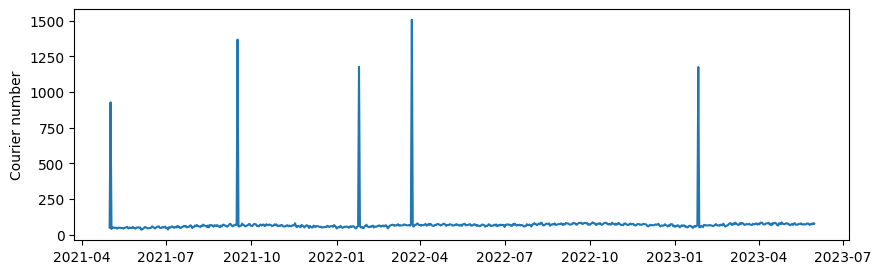

In [65]:
plt.figure(figsize=(10, 3)) 
plt.plot (df_daily_activity["date"], df_daily_activity["courier_partners_online"])
plt.ylabel("Courier number")

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>The data have several outliers. Let's get rid of them, as well as from the several non-defined data
 </p>
</div>

In [66]:
anomaly_threshold = 500
df_daily_activity_cleaned = df_daily_activity.copy(deep= True)
df_daily_activity_cleaned.loc [df_daily_activity['courier_partners_online']>500, 'courier_partners_online'] = None
df_daily_activity_cleaned = df_daily_activity_cleaned.ffill()

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Look at different time series to see clear correlation between courier activity, temperature and percipitation.
 </p>
</div>

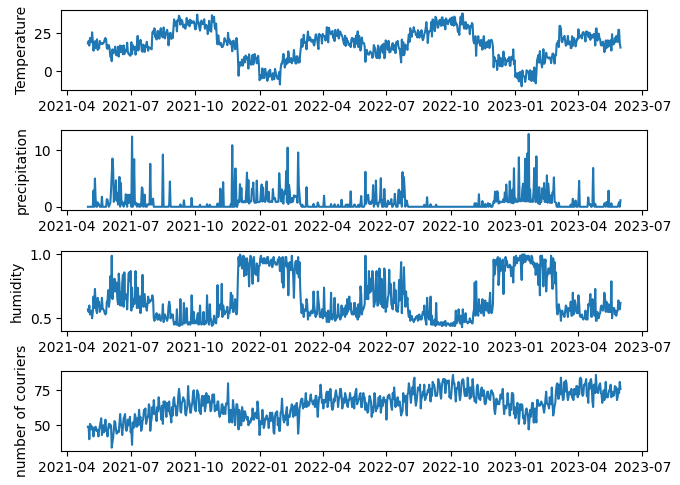

In [67]:
fig, ax = plt.subplots(4,1, figsize =(7,5))
ax[0].plot(df_daily_activity_cleaned["date"], df_daily_activity_cleaned["temperature"])
ax[0].set_ylabel("Temperature")

ax[1].plot(df_daily_activity_cleaned["date"], df_daily_activity_cleaned["precipitation"])
ax[1].set_ylabel("precipitation")

ax[2].plot(df_daily_activity_cleaned["date"], df_daily_activity_cleaned["relative_humidity"])
ax[2].set_ylabel("humidity")

ax[3].plot(df_daily_activity_cleaned["date"], df_daily_activity_cleaned["courier_partners_online"])
ax[3].set_ylabel("number of couriers")

fig.tight_layout()

## Exploratory data analysis

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Let us look at correlations 
 </p>
</div>

In [68]:
# Correlation matrix between features
correlation_matrix = df_daily_activity_cleaned.corr()

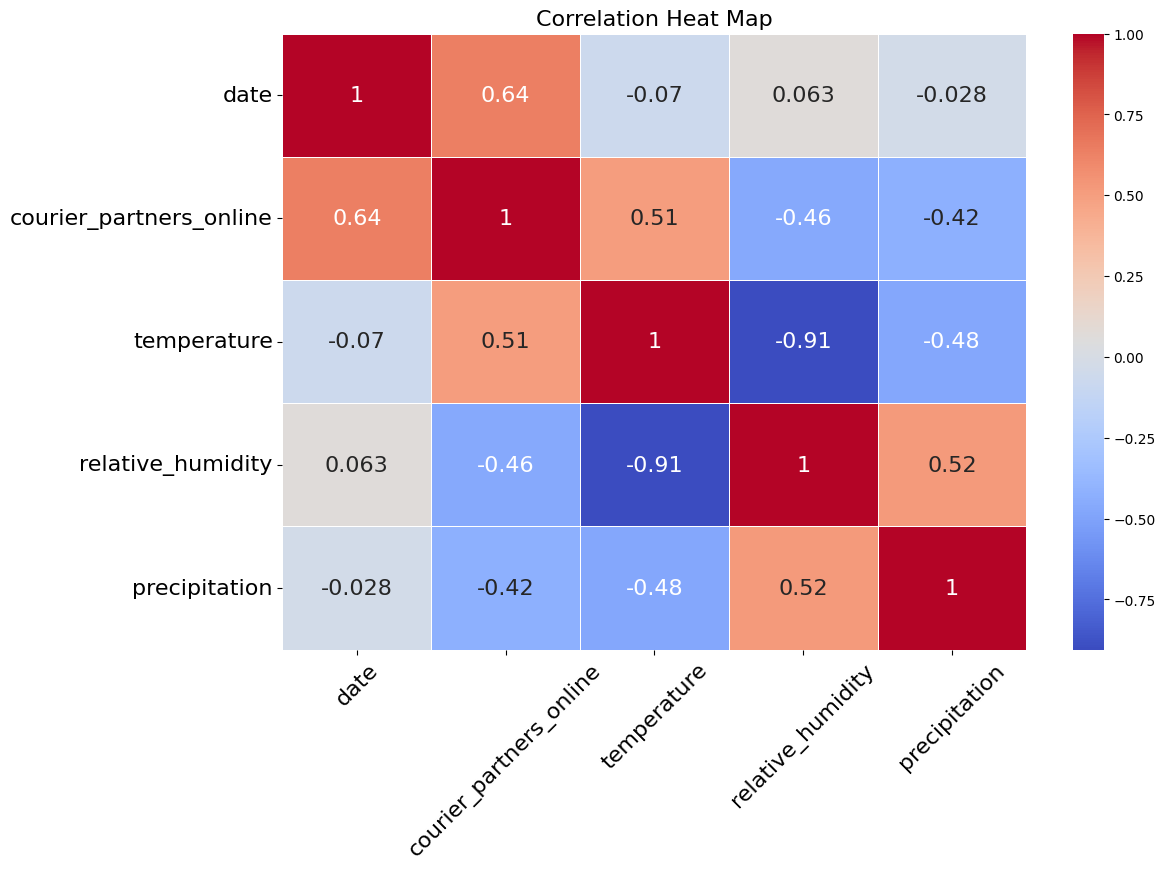

In [80]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 16})
plt.title('Correlation Heat Map')

# Title and axis label font size
plt.title('Correlation Heat Map', fontsize=16)

# Adjust tick font sizes
plt.xticks(fontsize=16, rotation=45)
plt.yticks(fontsize=16, rotation=0)

plt.show()

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Let us look at dependence between different features. Three panels below show that 'temperature', 'relative_humidity' and 'precipitation' are almost deterministically connected.
 </p>
</div>

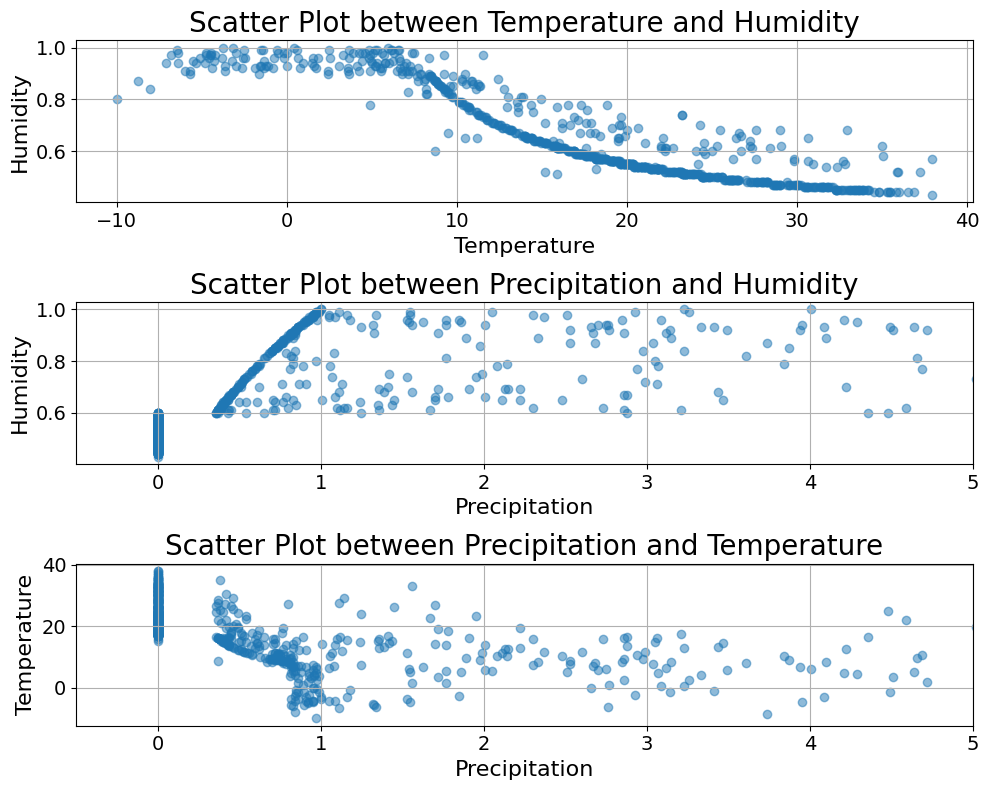

In [70]:
# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 8))

# Scatter plot between Temperature and Humidity
axs[0].scatter(df_daily_activity_cleaned['temperature'], df_daily_activity_cleaned['relative_humidity'], alpha=0.5)
axs[0].set_title('Scatter Plot between Temperature and Humidity', fontsize=20)
axs[0].set_xlabel('Temperature', fontsize=16)
axs[0].set_ylabel('Humidity', fontsize=16)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].grid(True)

# Scatter plot between Precipitation and Humidity
axs[1].scatter(df_daily_activity_cleaned['precipitation'], df_daily_activity_cleaned['relative_humidity'], alpha=0.5)
axs[1].set_title('Scatter Plot between Precipitation and Humidity', fontsize=20)
axs[1].set_xlabel('Precipitation', fontsize=16)
axs[1].set_ylabel('Humidity', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].set_xlim(-0.5, 5)
axs[1].grid(True)

# Scatter plot between Precipitation and Temperature
axs[2].scatter(df_daily_activity_cleaned['precipitation'], df_daily_activity_cleaned['temperature'], alpha=0.5)
axs[2].set_title('Scatter Plot between Precipitation and Temperature', fontsize=20)
axs[2].set_xlabel('Precipitation', fontsize=16)
axs[2].set_ylabel('Temperature', fontsize=16)
axs[2].tick_params(axis='both', which='major', labelsize=14)
axs[2].set_xlim(-0.5, 5)
axs[2].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

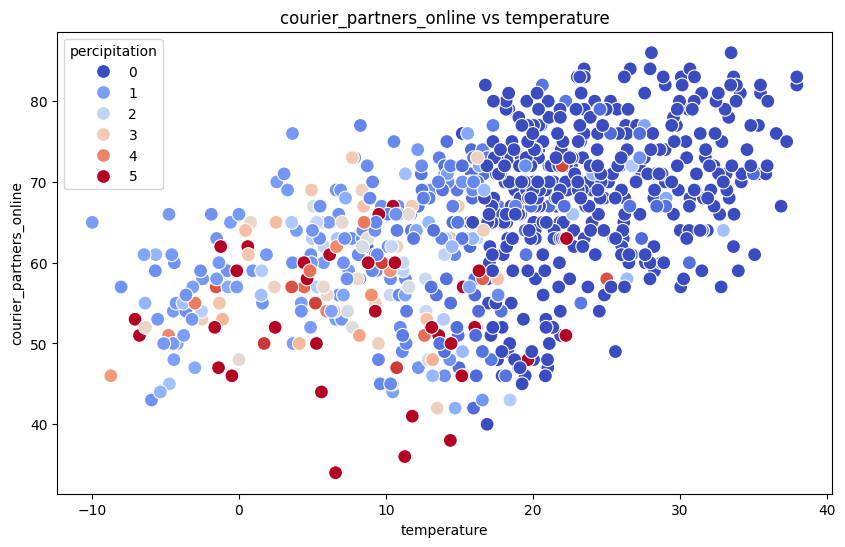

In [71]:
# Create a colorized scatter plot with a specific palette
df_daily_activity_cleaned_1 = df_daily_activity_cleaned.copy(deep=True)
df_daily_activity_cleaned_1["precipitation"] = df_daily_activity_cleaned_1['precipitation'].apply(lambda x: 5 if x > 5 else x)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_daily_activity_cleaned_1, x='temperature', y='courier_partners_online', hue='precipitation', palette='coolwarm', s=100)
plt.title('courier_partners_online vs temperature')
plt.xlabel('temperature')
plt.ylabel('courier_partners_online')
plt.legend(title='percipitation')
plt.show()

## Domain-Relevant feature engineering

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>From the correlation heat map above we see that largest correlations are with 'date', 'precipitation', 'temperature'.   
    For the Dataset we use historical values of these variables meaning their values in the certain number of days preceding the day at which target variable, that is 'courier_partners_online' is taken. We use categorical variables corresponding to the day of week, the date itself, periodical features corresponding to the day of year and day of week.  The values of 'courier_partners_online' in preceding days is also included as featuers.
 </p>
</div>

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Thus, in general we use as features the values of following variables in the N preceeding days: 'temperature',  'precipitation', 'day_of_week_i', 'days_since_start', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', 'day_of_week_cos', 'courier_partners_online'. 
 </p>


<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>We observe however that the feature 'days_since_start', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week_sin', 'day_of_week_cos' do not the model improve performance. You can experiment with selecting arbitrary set of features in the two the notebooks with model training and inference.
 </p>

</div>

In [72]:

df_daily_activity_cleaned['day_of_week'] = df_daily_activity_cleaned['date'].dt.dayofweek
df_daily_activity_cleaned = pd.get_dummies(df_daily_activity_cleaned, columns=['day_of_week'])

##################################33
# Define a reference date for trend calculation
start_date = df_daily_activity_cleaned['date'].min()
REFERENCE_DATE = start_date 

# Transform the 'date' column
df_daily_activity_cleaned['days_since_start'] = (df_daily_activity_cleaned['date'] - REFERENCE_DATE).dt.days
df_daily_activity_cleaned['day_of_year_sin'] = np.sin(2 * np.pi * df_daily_activity_cleaned['date'].dt.dayofyear / 365)
df_daily_activity_cleaned['day_of_year_cos'] = np.cos(2 * np.pi * df_daily_activity_cleaned['date'].dt.dayofyear / 365)


df_daily_activity_cleaned.head()

,date,courier_partners_online,temperature,relative_humidity,precipitation,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,days_since_start,day_of_year_sin,day_of_year_cos
0,2021-05-01,49.0,18.27,0.57,0.0,False,False,False,False,False,True,False,0,0.871706,-0.490029
1,2021-05-02,49.0,19.88,0.55,0.0,False,False,False,False,False,False,True,1,0.863142,-0.504961
2,2021-05-03,40.0,16.88,0.60,0.0,True,False,False,False,False,False,False,2,0.854322,-0.519744
3,2021-05-04,51.0,21.88,0.53,0.0,False,True,False,False,False,False,False,3,0.845249,-0.534373
4,2021-05-05,50.0,21.11,0.54,0.0,False,False,True,False,False,False,False,4,0.835925,-0.548843


<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
  <p> 
   Define feature list
  </p>
</div>

In [73]:
features = ['courier_partners_online', 'precipitation', 'temperature'] + \
    [col for col in df_daily_activity_cleaned.columns if col.startswith('day_of_week')]
# Update the features list to include the new date features'
#print(len(features))

date_features = ['days_since_start', 'day_of_year_sin', 'day_of_year_cos']
#features += date_features

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
  <p> 
    To train, test, and validate the model, we will split the data into training, validation, and testing sets. We will use the first 70% portion of the data for training, the middle portion 10% for validation, and the last 20% portion for testing. 
  </p>
</div>

In [74]:
duration_train = int(0.6*df_daily_activity_cleaned.shape [0])
duration_val = int(0.2*df_daily_activity_cleaned.shape [0])
start_date = (df_daily_activity_cleaned["date"].iloc[0])

# Calculate the validation start date
SPLIT_DATE_TRAIN_END = start_date + timedelta(duration_train)
SPLIT_DATE_TEST = start_date + timedelta(duration_train) + timedelta(duration_val)

SPLIT_DATE_TRAIN_END = SPLIT_DATE_TRAIN_END.strftime("%Y-%m-%d")
SPLIT_DATE_TEST = SPLIT_DATE_TEST.strftime("%Y-%m-%d")

print(SPLIT_DATE_TRAIN_END, SPLIT_DATE_TEST)

SPLIT_DATE_TEST = "2023-01-01"
SPLIT_DATE_TRAIN_END = "2022-10-15"

#SPLIT_DATE_TRAIN_END = "2022-07-31"

2022-07-31 2022-12-30


# Prediction tasks : Next-Day and Multiple-Day tasks

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Next-Day task consists of predicting the 'courier_partners_online' variable for the next day based on the information available for the previous days.
 </p>
</div>

<div style="background-color: #f2f2f2; color: #333333; padding: 10px; font-size: 20px;">
    <p>Multiple-Day task consists of predicting the 'courier_partners_online' variable values for the several next days based on the information available for the previous days.
 </p>
</div>

## Metrics

To measure performace of prediction we use several metrices descibed below. These metrices are calculated using scripts as described in README.md file.

Mean Absolute Error (MAE)
$$
    \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| y_i - \hat{y}_i \right|
$$

Mean Squared Error (MSE)
$$
    \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 
$$

Root Mean Squared Error (RMSE)
$$ 
    \text{RMSE} = \sqrt{
        \frac{1}{n} \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2
        } 
$$

Signal-to-Noise Ratio (SNR)

$$
 \text{SNR (dB)} = 10 \log_{10} 
 \left( 
    \frac{
          \sum_{i=1}^{n} \hat{y}_i^2
        }
        { 
           \sum_{i=1}^{n} \left( y_i - \hat{y}_i \right)^2 
        } 
 \right) 
$$

Here
-$ y_i $ and  $ \hat{y}_i $ The actual value of courier numbers on the (i)-th day.
- $ \hat{y}_i $: The predicted value at the (i)-th position.
- $ n $: The total number of observations.
These equations provide a mathematical representation of the error metrics used to evaluate the performance of regression models.

## Conclusions

Using these features and dataset split me train and validate models in other notebooks.
